# 
<h1 style="color: teal;">2D Deconvolution Benchmark: Julia</h1>

---
## Setup

In [90]:
using DeconvOptim, TestImages, Colors, ImageIO, Noise, ImageShow, Images, Plots, BenchmarkTools, FFTW, NPZ

---
## Test Image

Una vez importados los paquetes lo que hemos hecho ha sido coger una imagen de prueba, añadirla borrosidad y ruido y hacer la deconvolución en 2D sin regularizar.
Usaremos la misma PSF para el código en python y el mismo número de iteraciones.


### Generación de imagen borrosa y PSF

In [91]:
# Cargar la imagen de prueba
img = testimage("resolution_test_512")
img = Float32.(img)

# Generar la PSF (Point Spread Function)
psf = Float32.(generate_psf(size(img), 30))

# Normalizar la PSF para que conserve la energía
psf_normalized = psf ./ sum(psf)

# Centrar la PSF utilizando ifftshift
centered_psf = ifftshift(psf_normalized)

# Crear una versión borrosa y ruidosa de la imagen
img_b = imfilter(img, centered_psf)   # Imagen borrosa
img_n = poisson(img_b, 300)           # Imagen borrosa y ruidosa


# Guardar la PSF para los test
#npzwrite("test_psf.npy", centered_psf)

# Guardar la PSF de manera visible
#psf_vis = centered_psf ./ maximum(centered_psf)   # escala entre 0 y 1
#save("psf_visual.png", psf_vis)

# Guardar la imagen borrosa y ruidosa para test
#npzwrite("imagen_borrosa.npy", img_b)

# Guardar la imagen borrosa y ruidosa para visualizacion
#save("blurrednoisy_img.png", img_b)


512×512 Matrix{Float32}:
 0.0         0.0         0.0         …  0.0         0.0  0.0
 0.0         0.00581478  0.0            0.0         0.0  0.00290739
 0.0         0.0         0.0            0.0         0.0  0.00290739
 0.0         0.0         0.0            0.00290739  0.0  0.0
 0.00290739  0.00290739  0.0            0.00290739  0.0  0.00290739
 0.0         0.00290739  0.0         …  0.00290739  0.0  0.0
 0.0         0.0         0.0            0.00290739  0.0  0.0
 0.00290739  0.00290739  0.0            0.0         0.0  0.00290739
 0.0         0.0         0.0            0.0         0.0  0.0
 0.0         0.0         0.0            0.0         0.0  0.0
 ⋮                                   ⋱              ⋮    
 0.0         0.0         0.0            0.0         0.0  0.0
 0.0         0.0         0.0            0.0         0.0  0.00290739
 0.0         0.0         0.00290739  …  0.0         0.0  0.0
 0.00290739  0.0         0.0            0.0         0.0  0.0
 0.0         0.0         0.0

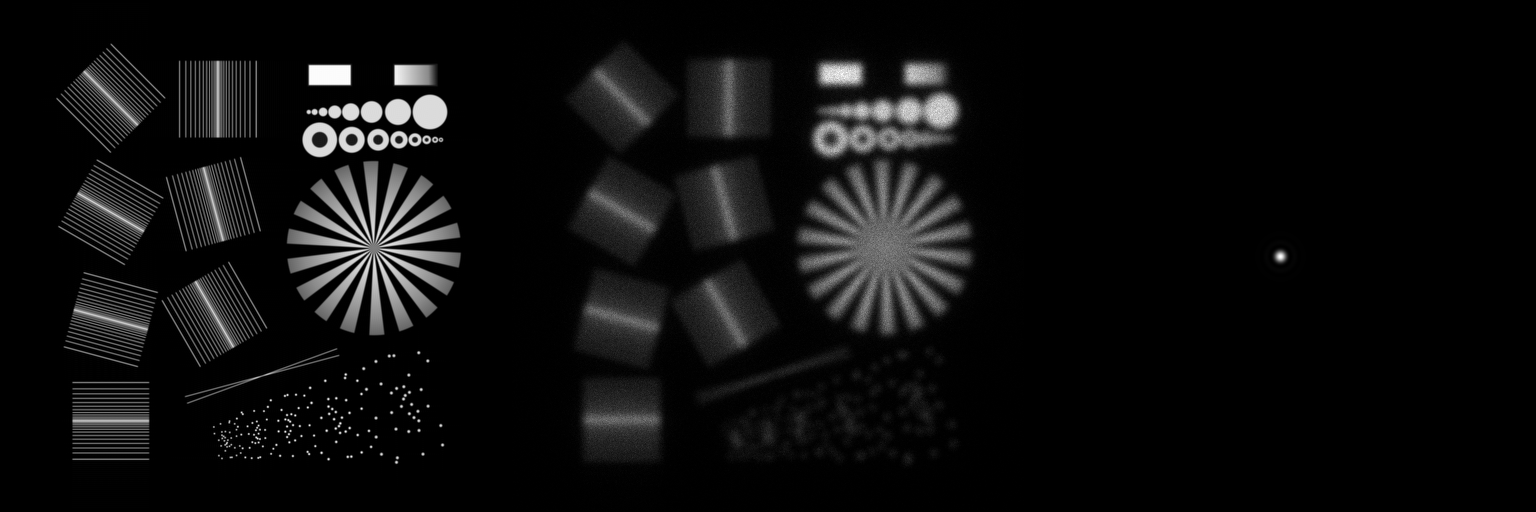

In [92]:
Gray.([img img_n psf_vis])

### Si ya tenemos la imagen borrosa y la PSF las caragmos

In [93]:
img_n_1 = load("ImagenesEmpleadas2D/imagen_borrosa.npy")
img_n_1 = Float32.(img_n_1)

psf_1 = load("ImagenesEmpleadas2D/test_psf.npy")
psf_1 = Float32.(psf_1);
# Deconvolución 2D sin regularizador
res_no_reg, o = deconvolution(img_n_1, ifftshift(psf_1), regularizer=nothing, iterations=30)

# Medir el tiempo de ejecución de la deconvolución

b = @benchmark  deconvolution(img_n_1, ifftshift(psf_1), regularizer=nothing, iterations=30) samples=15 evals=1

BenchmarkTools.Trial: 15 samples with 1 evaluation.
 Range (min … max):  224.483 ms … 407.394 ms  ┊ GC (min … max): 1.18% … 43.40%
 Time  (median):     228.941 ms               ┊ GC (median):    1.15%
 Time  (mean ± σ):   243.927 ms ±  46.788 ms  ┊ GC (mean ± σ):  5.85% ± 10.95%

  █▁                                                             
  ██▇▄▄▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  224 ms           Histogram: frequency by time          407 ms <

 Memory estimate: 173.58 MiB, allocs estimate: 5829.

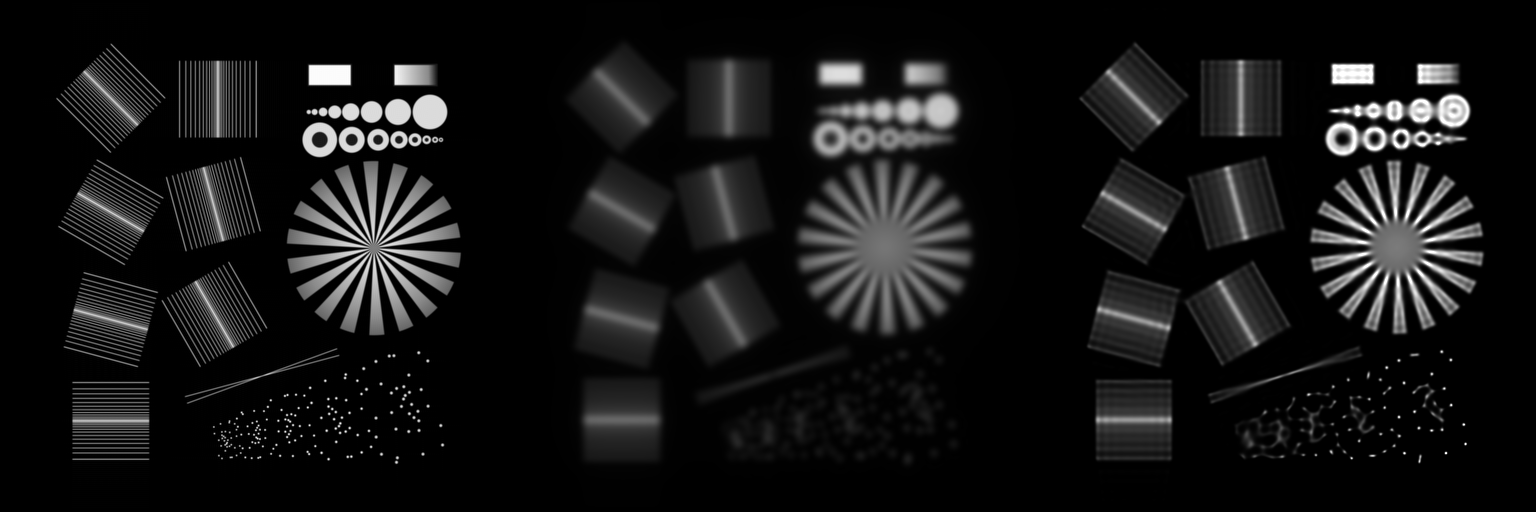

In [94]:
# Mostrar los resultados finales junto a la versión original y la versión borrosa
Gray.([img img_n_1 res_no_reg])

Ahora vamos a usar la función richardson_lucy_iterative del módulo deconvoptim.jl sin regularización.

In [95]:
# Deconvolución iterativa de Richardson-Lucy sin regularizador
restored_img = richardson_lucy_iterative(img_n_1, ifftshift(psf_1); regularizer=nothing, iterations=30);

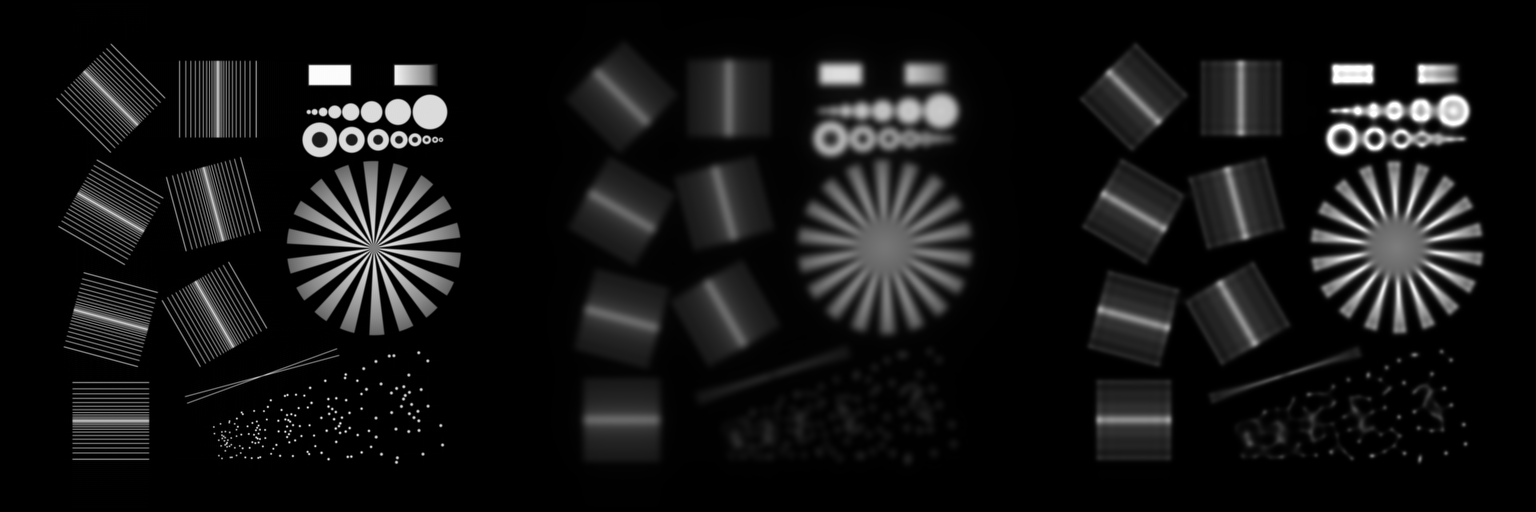

In [96]:
Gray.([img img_n_1 restored_img])

In [97]:
c = @benchmark richardson_lucy_iterative(img_n_1, ifftshift(psf_1); regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  58.484 ms … 98.644 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     58.819 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   59.685 ms ±  4.297 ms  ┊ GC (mean ± σ):  0.54% ± 2.38%

  █▇▄▃                                                         
  █████▅▇▁▁▁▁▁▁▁▁▅▁▁▅▆▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅ ▅
  58.5 ms      Histogram: log(frequency) by time      72.9 ms <

 Memory estimate: 8.01 MiB, allocs estimate: 35.

Veremos ahora ejemplos con TV regularization en Julia

In [98]:
# Deconvolución iterativa de Richardson-Lucy con regularizador
optim_res = richardson_lucy_iterative(img_n_1, ifftshift(psf_1), λ=0.05, regularizer=TV(), iterations=30)
d1 = @benchmark richardson_lucy_iterative(img_n_1, ifftshift(psf_1), λ=0.05, regularizer=TV(), iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  282.284 ms … 347.881 ms  ┊ GC (min … max): 0.00% … 2.88%
 Time  (median):     296.581 ms               ┊ GC (median):    2.92%
 Time  (mean ± σ):   296.235 ms ±   9.891 ms  ┊ GC (mean ± σ):  2.11% ± 1.73%

     █▂▂         ▄▂▂  ▂                                          
  ▃▅▃███▃▆▁▆▅▁▅█████████▆▃▅▅▃▅▃▅▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▃
  282 ms           Histogram: frequency by time          337 ms <

 Memory estimate: 77.53 MiB, allocs estimate: 631189.

In [99]:
# Deconvolución iterativa de Richardson-Lucy con regularizador (optimizada)
tv = TV()

#887 (generic function with 1 method)

In [100]:
d2 = @benchmark richardson_lucy_iterative(img_n_1, ifftshift(psf_1), λ=0.05, regularizer=tv, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  76.956 ms … 261.037 ms  ┊ GC (min … max): 0.00% … 70.05%
 Time  (median):     78.154 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   80.504 ms ±  18.314 ms  ┊ GC (mean ± σ):  3.40% ±  7.18%

  ▁▄█                                                           
  ███▆▇▅▆▅▆▅▅▇▁▄▅▅▁▃▄▁▄▆▅▅▄▄▁▁▄▁▁▁▁▁▃▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▃
  77 ms           Histogram: frequency by time         86.8 ms <

 Memory estimate: 39.04 MiB, allocs estimate: 1059.

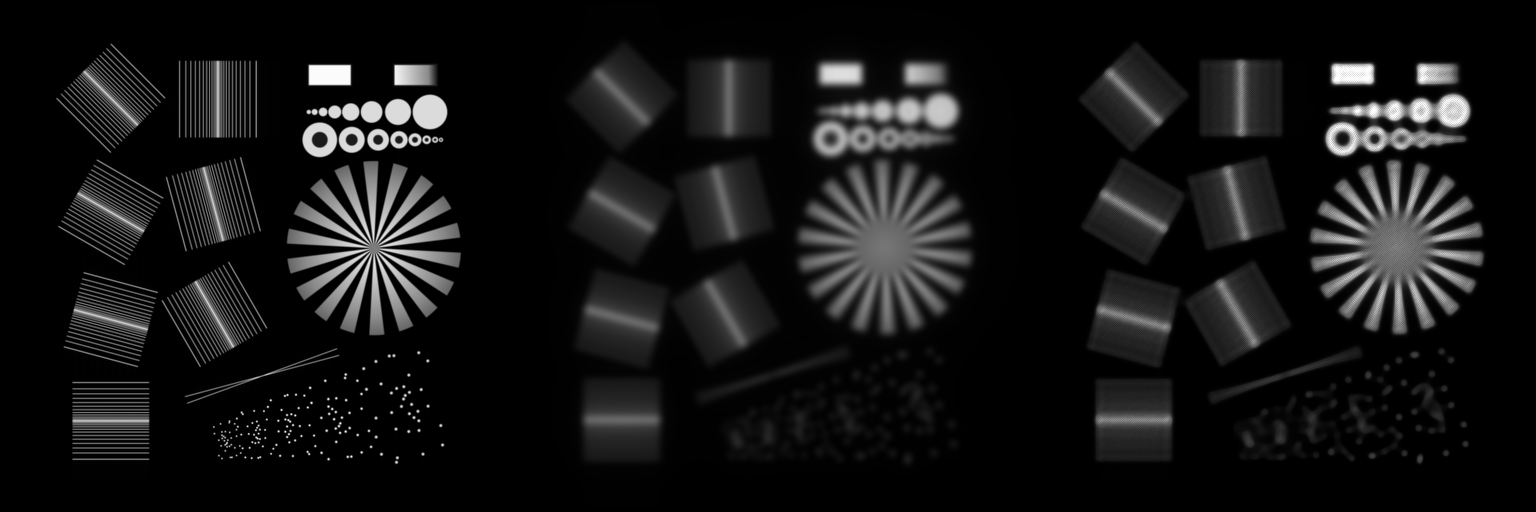

In [101]:
Gray.([img img_n_1 optim_res])

---
## Cell
Test usando solo el plano central del `cells3D` dataset

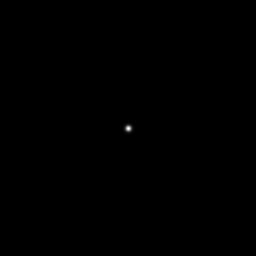

In [102]:
img = load("ImagenesEmpleadas2D/2d_cell_imgborrosa.npy")
img = Float32.(img)

psf = load("ImagenesEmpleadas2D/2d_cell_psf_test.npy")
psf = Float32.(psf)

Gray.(psf/maximum(psf))

In [103]:
ipsf = ifftshift(psf);

In [104]:
deconvolved = richardson_lucy_iterative(img, ipsf; regularizer=nothing, iterations=30);

In [105]:
 c = @benchmark richardson_lucy_iterative(img, ipsf; regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  15.281 ms … 54.731 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.383 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.792 ms ±  3.935 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

      █▃▄▄▁                                                    
  ▄▄▆▄█████▆▇▅▃▁▃▃▁▁▃▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▃
  15.3 ms         Histogram: frequency by time        16.2 ms <

 Memory estimate: 1.76 MiB, allocs estimate: 33.

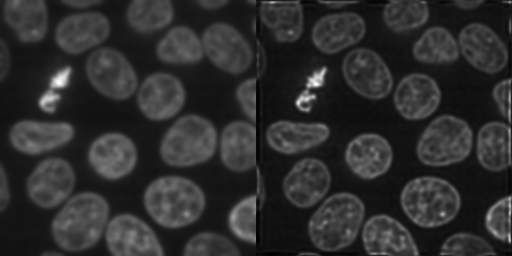

In [106]:
Gray.([img/maximum(img) deconvolved/maximum(deconvolved)])

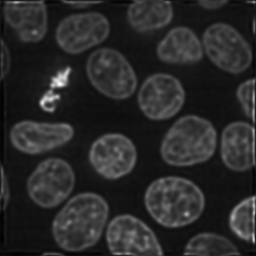

In [107]:
using Images
using ImageIO

# Convertimos a formato Gray (escala de grises)
gray_img = Gray.(img/maximum(img))
gray_deconv = Gray.(deconvolved/maximum(deconvolved))

# Guardar como PNG
#save("maximum_img.png", gray_img)
#save("maximum_deconvolved.png", gray_deconv)
